In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import datetime
import os
import pickle
import re
from tensorflow.python.ops import math_ops

## 先来看看数据

本项目使用的是MovieLens 1M 数据集，包含6000个用户在近4000部电影上的1亿条评论。

数据集分为三个文件：用户数据users.dat，电影数据movies.dat和评分数据ratings.dat。

### 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。

数据中的格式：UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [2]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
print(users.shape)
users.head()

(6040, 5)


,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


可以看出UserID、Gender、Age和Occupation都是类别字段，其中邮编字段是我们不使用的。

### 电影数据
分别有电影ID、电影名和电影风格等字段。

数据中的格式：MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [3]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
print(movies.shape)
movies.head()

(3883, 3)


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


MovieID是类别字段，Title是文本，Genres也是类别字段

### 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [4]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
print(ratings.shape)
ratings.head()

(1000209, 4)


,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 来说说数据预处理

- UserID、Occupation和MovieID不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。
- Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

## 实现数据预处理

In [5]:
#用户数据预处理
users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
#将Zip-code过滤掉
users = users.filter(regex='UserID|Gender|Age|JobID')
#users_orig是没有做数据处理的原始用户数据
users_orig = users.values
#改变User数据中性别和年龄(女性为0，男性为1)
gender_map = {'F':0, 'M':1}
users['Gender'] = users['Gender'].map(gender_map)
    
#set函数是将其去重，然后通过enumerate函数进行遍历，ii是序号，val是值
#将7种不同的年龄分别对应0~6(不是有序排列，也就是说并不是年龄小的在前面，年龄大的在后面)
age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
users['Age'] = users['Age'].map(age_map)
users.head(10)

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20
5,6,0,3,9
6,7,1,1,1
7,8,1,6,12
8,9,1,6,17
9,10,0,1,1


In [6]:
#电影数据预处理
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
#movies_orig是没有做数据处理的原始电影数据
movies_orig = movies.values
#将Title中的年份去掉（正则表达式）
pattern = re.compile(r'^(.*)\((\d+)\)$')

title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
movies['Title'] = movies['Title'].map(title_map)

#电影类型转数字字典
#genres_set.update(val)是将val合并到genres_set中，相同的元素只会出现一次
genres_set = set()
for val in movies['Genres'].str.split('|'):
    genres_set.update(val)
#genres_set是得出所有的电影种类
genres_set.add('<PAD>')
#genres2int是给电影种类编号的字典（通过值查找编号）
genres2int = {val:ii for ii, val in enumerate(genres_set)}

#将电影类型转成等长数字列表，如'Comedy|Horror': [7, 15]
genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}
#为其添加填充值，使得它的长度为18（因为有的电影所属的类别数量不一样，为了做到统一）
for key in genres_map:
    #max(genres2int.values())就是18
    for cnt in range(max(genres2int.values()) - len(genres_map[key])):
        #这是在它的后面从第len个位置开始插入'<PAD>'的编号
        genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
movies['Genres'] = movies['Genres'].map(genres_map)

#电影Title转数字字典
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val)
    
title_set.add('<PAD>')
#获取title中的所有的词，并给它编号（title文本的集合）
title2int = {val:ii for ii, val in enumerate(title_set)}
#print(max(title2int.values()))
print(len(title_set))

#将电影Title转成等长数字列表，长度是15（因为不同的title的词的长度不一样,取15是因为几乎没有电影的名字有15个词）
title_count = 15
title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        #这是在title词向量的后面插入'<PAD>'的编号
        title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
#类似于电影类型
movies['Title'] = movies['Title'].map(title_map)
print(movies_orig)
movies.head(10)

5215
[[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
 [2 'Jumanji (1995)' "Adventure|Children's|Fantasy"]
 [3 'Grumpier Old Men (1995)' 'Comedy|Romance']
 ...
 [3950 'Tigerland (2000)' 'Drama']
 [3951 'Two Family House (2000)' 'Drama']
 [3952 'Contender, The (2000)' 'Drama|Thriller']]


,MovieID,Title,Genres
0,1,"[2180, 2820, 1227, 1227, 1227, 1227, 1227, 122...","[12, 5, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
1,2,"[2894, 1227, 1227, 1227, 1227, 1227, 1227, 122...","[17, 5, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
2,3,"[2151, 2345, 4902, 1227, 1227, 1227, 1227, 122...","[2, 16, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
3,4,"[2469, 2251, 4181, 1227, 1227, 1227, 1227, 122...","[2, 18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
4,5,"[4038, 824, 2249, 3169, 1658, 2452, 1227, 1227...","[2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
5,6,"[4087, 1227, 1227, 1227, 1227, 1227, 1227, 122...","[9, 7, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
6,7,"[3295, 1227, 1227, 1227, 1227, 1227, 1227, 122...","[2, 16, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
7,8,"[4714, 1073, 2080, 1227, 1227, 1227, 1227, 122...","[17, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
8,9,"[1494, 605, 1227, 1227, 1227, 1227, 1227, 1227...","[9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ..."
9,10,"[3177, 1227, 1227, 1227, 1227, 1227, 1227, 122...","[9, 17, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."


In [7]:
#评分数据预处理
ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
#将时间戳过滤掉
ratings = ratings.filter(regex='UserID|MovieID|ratings')
ratings.head(10)

,UserID,MovieID,ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [8]:
#合并三个表
data = pd.merge(pd.merge(ratings, users), movies)
    
#将数据分成X和y两张表
target_fields = ['ratings']
#分为特征表和目标表（特征表剔除了评分数据，目标表保留了评分数据）
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
features = features_pd.values
targets_values = targets_pd.values
    
print(features_pd)
print('\n')
print(targets_pd)
data

         UserID  MovieID  Gender  Age  JobID  \
0             1     1193       0    0     10   
1             2     1193       1    5     16   
2            12     1193       1    6     12   
3            15     1193       1    6      7   
4            17     1193       1    3      1   
...         ...      ...     ...  ...    ...   
1000204    5949     2198       1    4     17   
1000205    5675     2703       1    1     14   
1000206    5780     2845       1    4     17   
1000207    5851     3607       0    4     20   
1000208    5938     2909       1    6      1   

                                                     Title  \
0        [3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...   
1        [3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...   
2        [3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...   
3        [3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...   
4        [3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...   
...                                                

,UserID,MovieID,ratings,Gender,Age,JobID,Title,Genres
0,1,1193,5,0,0,10,"[3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...","[18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
1,2,1193,5,1,5,16,"[3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...","[18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
2,12,1193,4,1,6,12,"[3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...","[18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
3,15,1193,4,1,6,7,"[3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...","[18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
4,17,1193,5,1,3,1,"[3241, 2445, 620, 2249, 424, 617, 1227, 1227, ...","[18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,1,4,17,"[3389, 1227, 1227, 1227, 1227, 1227, 1227, 122...","[13, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
1000205,5675,2703,3,1,1,14,"[1397, 3061, 1227, 1227, 1227, 1227, 1227, 122...","[18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
1000206,5780,2845,1,1,4,17,"[2853, 3898, 1227, 1227, 1227, 1227, 1227, 122...","[18, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."
1000207,5851,3607,5,0,4,20,"[3241, 4289, 1290, 1227, 1227, 1227, 1227, 122...","[2, 18, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,..."


### 加载数据并保存到本地

- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [10]:
#为方便调用，将其写在一个函数中
def load_data():
    #用户数据预处理
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    #将Zip-code过滤掉
    users = users.filter(regex='UserID|Gender|Age|JobID')
    #获取值，过滤掉标题
    users_orig = users.values
    #改变User数据中性别和年龄(女性为0，男性为1)
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)
    
    #set函数是将其去重，然后通过enumerate函数进行遍历，ii是序号，val是值
    #将7种不同的年龄分别对应0~6(不是有序排列，也就是说并不是年龄小的在前面，年龄大的在后面)
    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)
    
    
    #电影数据预处理
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉（正则表达式）
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    #genres_set.update(val)是将val合并到genres_set中，相同的元素只会出现一次
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)
    #genres_set是得出所有的电影种类
    genres_set.add('<PAD>')
    #genres2int是给电影种类编号的字典（通过值查找编号）
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，如'Comedy|Horror': [7, 15]
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}
    #为其添加填充值，使得它的长度为18（因为有的电影所属的类别数量不一样，为了做到统一）
    for key in genres_map:
        #max(genres2int.values())就是18
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            #这是在它的后面从第len个位置开始插入'<PAD>'的编号
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])

    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)

    title_set.add('<PAD>')
    #获取title中的所有的词，并给它编号（title文本的集合）
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15（因为不同的title的词的长度不一样,取15是因为几乎没有电影的名字有15个词）
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}

    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            #这是在title词向量的后面插入'<PAD>'的编号
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    #类似于电影类型
    movies['Title'] = movies['Title'].map(title_map)
    
    
    #评分数据预处理
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    #将时间戳过滤掉
    ratings = ratings.filter(regex='UserID|MovieID|ratings')
    
    
    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)

    #将数据分成X和y两张表
    target_fields = ['ratings']
    #分为特征表和目标表（特征表剔除了评分数据，目标表保留了评分数据）
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    #剔除了评分数据的特征表的值
    features = features_pd.values
    #由评分数据组成的目标表的值
    targets_values = targets_pd.values

    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

In [11]:
#加载数据
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()
#将对象obj保存到文件file中去
#pickle.dump用于保存文件
pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('./save_data/preprocess.p','wb'))

In [12]:
#从本地文件中读取数据
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('./save_data/preprocess.p', mode='rb'))

## 模型设计

<img src="assets/model.001.jpeg"/>

通过研究数据集中的字段类型，我们发现有一些是类别字段，通常的处理是将这些字段转成one hot编码，但是像UserID、MovieID这样的字段就会变成非常的稀疏，输入的维度急剧膨胀，这是我们不愿意见到的，毕竟我这小笔记本不像大厂动辄能处理数以亿计维度的输入：）

所以在预处理数据时将这些字段转成了数字，我们用这个数字当做嵌入矩阵的索引，在网络的第一层使用了嵌入层，维度是（N，32）和（N，16）。

电影类型的处理要多一步，有时一个电影有多个电影类型，这样从嵌入矩阵索引出来是一个（n，32）的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成（1，32）的向量。

电影名的处理比较特殊，没有使用循环神经网络，而是用了文本卷积网络，下文会进行说明。

从嵌入层索引出特征以后，将各特征传入全连接层，将输出再次传入全连接层，最终分别得到（1，200）的用户特征和电影特征两个特征向量。

我们的目的就是要训练出用户特征和电影特征，在实现推荐功能时使用。得到这两个特征以后，就可以选择任意的方式来拟合评分了。我使用了两种方式，一个是上图中画出的将两个特征做向量乘法，将结果与真实评分做回归，采用MSE优化损失。因为本质上这是一个回归问题，另一种方式是，将两个特征作为输入，再次传入全连接层，输出一个值，将输出值回归到真实评分，采用MSE优化损失。

实际上第二个方式的MSE loss在0.8附近，第一个方式在1附近，5次迭代的结果。

## 文本卷积网络
网络看起来像下面这样

<img src="assets/text_cnn.png"/>
图片来自Kim Yoon的论文：[`Convolutional Neural Networks for Sentence Classification`](https://arxiv.org/abs/1408.5882)

将卷积神经网络用于文本的文章建议你阅读[`Understanding Convolutional Neural Networks for NLP`](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

网络的第一层是词嵌入层，由每一个单词的嵌入向量组成的嵌入矩阵。下一层使用多个不同尺寸（窗口大小）的卷积核在嵌入矩阵上做卷积，窗口大小指的是每次卷积覆盖几个单词。这里跟对图像做卷积不太一样，图像的卷积通常用2x2、3x3、5x5之类的尺寸，而文本卷积要覆盖整个单词的嵌入向量，所以尺寸是（单词数，向量维度），比如每次滑动3个，4个或者5个单词。第三层网络是max pooling得到一个长向量，最后使用dropout做正则化，最终得到了电影Title的特征。

## 辅助函数

In [13]:
import tensorflow as tf
import os
import pickle

#将参数保存到文件中
def save_params(params):
    pickle.dump(params, open('./save_data/params.p', 'wb'))

#从文件中读取参数
def load_params():
    return pickle.load(open('./save_data/params.p', mode='rb'))

## 编码实现

In [14]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
#ndarray.take(indices, axis=None, out=None, mode='raise')
#按axis选择处于indices位置上的值
#axis用于选择值的轴，0为横轴，1为纵向选
#如features.take(0,0)就会选择横向第一条数据，(1,0)会选择横向第二条数据
#因为是从0开始，所以要+1
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3883
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5215

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
#另外91号电影并不在数据集中，要考虑存在空缺值的情况
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参

In [15]:
#循环次数
num_epochs = 5
#每个批次的大小
batch_size = 256

#剔除神经元的比例
dropout_keep = 0.5
#学习率
learning_rate = 0.0001
#显示每n个批次的统计数据（每n个批次打印一下数据）
show_every_n_batches = 20

save_dir = './save_model/save'

### 输入

定义输入的占位符

In [16]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    #电影的种类，N行18列
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    #电影的名字，N行15列
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    #评分
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

## 构建神经网络

#### 定义User的嵌入矩阵

In [17]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        #tf.Variable(initializer,name)：initializer是初始化参数，可以有tf.random_normal,tf.constant等,name是变量的名字
        #tf.random_uniform(shape, minval=0,maxval=None,dtype=tf.float32) 从均匀分布中输出随机值。
        #返回shape形状矩阵：用户数uid_max×特征数embed_dim，产生于low(-1)和high(1)之间，产生的值是均匀分布的。
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        #tf.nn.embedding_lookup(tensor, id) 选取一个张量tensor里面索引id对应的元素
        #选取uid_embed_matrix（用户ID嵌入矩阵）中的用户id对应的某个用户id的向量
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
        
        #特征数降一半
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        #选取gender_embed_matrix（用户性别嵌入矩阵）的用户性别对应的某个用户性别的向量
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 将User的嵌入矩阵一起全连接生成User的特征

In [18]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #构建各属性的全连接层
        # tf.layers.dense(inputs,units,activation=None,use_bias=True,kernel_initializer=None,bias_initializer=tf.zeros_initializer(),
        # kernel_regularizer=None,bias_regularizer=None,activity_regularizer=None,kernel_constraint=None,
        #bias_constraint=None,trainable=True,name=None,reuse=None)
        #inputs:该层的输入; units:输出的大小(维数),整数或long; activation: 使用什么激活函数（神经网络的非线性层），默认为None，不使用激活函数
        #name该层的名字
        #即以用户ID嵌入层作为输入，输出维度为嵌入矩阵的维度，采用relu激活函数，dense是新增加一层。
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        #以用户性别嵌入层作为输入，输出维度为嵌入矩阵的维度
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第一层全连接
        #tf.concat(values,axis,name)是连接两个矩阵的操作，本身不会增加维度，返回的是连接后的tensor.
        #values应该是一个tensor的list或者tuple。
        #axis则是我们想要连接的维度。对于二维来说0表示第一个括号维度，1表示第二个括号维度
        #t1 = [[1, 2, 3], [4, 5, 6]]
        #t2 = [[7, 8, 9], [10, 11, 12]]
        #tf.concat([t1, t2], 0)表示为 [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
        #tf.concat([t1, t2], 1)表示为 [[1, 2, 3, 7, 8, 9], [4, 5, 6, 10, 11, 12]]
        #对于三维来说0表示第一个括号维度，1表示第二个括号维度，2表示第三个括号维度
        #t1 = [ [[1],[2]] , [[3],[4]] ]
        #t2 = [ [[5],[6]] , [[7],[8]] ]
        #tf.concat([t1, t2], 0)表示为[[[1],[2]] , [[3],[4]] , [[5],[6]] , [[7],[8]]]
        #tf.concat([t1, t2], 1)表示为[[[1],[2],[5],[6]],[[3],[4],[7],[8]]]
        #tf.concat([t1, t2], 2)表示为[[[1 5],[2 6]],[[3 7],[4 8]]]
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)  4*32=128
        #tf.contrib.layers.fully_connected（F输入, num_outputs,activation_fn）用于构建全连接层
        #第二层全连接
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
        #-1表示缺省值，满足其他维度要求，这里该是几就是几，(?, 200）
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

#### 定义Movie ID的嵌入矩阵

In [19]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

#### 对电影类型的多个嵌入向量做加和

In [20]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        #选取电影种类嵌入矩阵中对应的某个电影种类的向量，也是一个32维的向量
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
             #tf.reduce_sum(input_tensor,axis=None,keep_dims=False,name=None,reduction_indices=None)要输出看！
             #压缩求和，用于降维
             #函数中的input_tensor是按照axis中已经给定的维度来减少的，axis表示按第几个维度求和
             #但是keep_dims为true，则维度不会减小
             #如果axis没有条目，则缩小所有维度，并返回具有单个元素的张量
             #'x' is [[1, 1, 1]
             # [1, 1, 1]]
             #求和tf.reduce_sum(x) ==> 6
             #按列求和tf.reduce_sum(x, 0) ==> [2, 2, 2]（即得到行结果）
             #按行求和tf.reduce_sum(x, 1) ==> [3, 3] （即得到列结果）
             #按照行的维度求和tf.reduce_sum(x, 1, keep_dims=True) ==> [[3], [3]]（维度不会减少）
             #x现在一行为一个类型向量，应该按axis=1进行sum
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

#### Movie Title的文本卷积网络实现

In [21]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        #得到电影标题词嵌入矩阵，维度为32维
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        #movie_title_embed_layer从电影标题词嵌入矩阵中选取某个电影标题词的向量
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    #window_sizes = {2, 3, 4, 5}，分别取2,3,4,5这四个步长
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

#### 将Movie的各个层一起做全连接

In [22]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

## 构建计算图

In [23]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
# tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


## 取得batch

In [24]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 训练网络

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')

Writing to E:\jupyter\RecommendSystem\runs\1571488305

2019-10-19T20:31:48.840528: Epoch   0 Batch    0/3125   train_loss = 8.713
2019-10-19T20:31:49.328516: Epoch   0 Batch   20/3125   train_loss = 3.891
2019-10-19T20:31:49.814214: Epoch   0 Batch   40/3125   train_loss = 3.010
2019-10-19T20:31:50.280874: Epoch   0 Batch   60/3125   train_loss = 2.304
2019-10-19T20:31:50.739314: Epoch   0 Batch   80/3125   train_loss = 2.027
2019-10-19T20:31:51.210808: Epoch   0 Batch  100/3125   train_loss = 1.917
2019-10-19T20:31:51.708236: Epoch   0 Batch  120/3125   train_loss = 1.784
2019-10-19T20:31:52.163104: Epoch   0 Batch  140/3125   train_loss = 1.649
2019-10-19T20:31:52.637939: Epoch   0 Batch  160/3125   train_loss = 1.499
2019-10-19T20:31:53.150723: Epoch   0 Batch  180/3125   train_loss = 1.327
2019-10-19T20:31:53.649943: Epoch   0 Batch  200/3125   train_loss = 1.624
2019-10-19T20:31:54.147729: Epoch   0 Batch  220/3125   train_loss = 1.539
2019-10-19T20:31:54.613045: Epoch   0 Batch  

2019-10-19T20:32:40.478662: Epoch   0 Batch 2180/3125   train_loss = 1.147
2019-10-19T20:32:40.950874: Epoch   0 Batch 2200/3125   train_loss = 1.089
2019-10-19T20:32:41.418152: Epoch   0 Batch 2220/3125   train_loss = 1.119
2019-10-19T20:32:41.957569: Epoch   0 Batch 2240/3125   train_loss = 0.975
2019-10-19T20:32:42.415580: Epoch   0 Batch 2260/3125   train_loss = 1.143
2019-10-19T20:32:42.900024: Epoch   0 Batch 2280/3125   train_loss = 1.189
2019-10-19T20:32:43.359509: Epoch   0 Batch 2300/3125   train_loss = 1.252
2019-10-19T20:32:43.838867: Epoch   0 Batch 2320/3125   train_loss = 1.324
2019-10-19T20:32:44.307375: Epoch   0 Batch 2340/3125   train_loss = 1.154
2019-10-19T20:32:44.781828: Epoch   0 Batch 2360/3125   train_loss = 1.153
2019-10-19T20:32:45.240052: Epoch   0 Batch 2380/3125   train_loss = 1.087
2019-10-19T20:32:45.710111: Epoch   0 Batch 2400/3125   train_loss = 1.221
2019-10-19T20:32:46.180049: Epoch   0 Batch 2420/3125   train_loss = 1.129
2019-10-19T20:32:46.66376

2019-10-19T20:33:20.541719: Epoch   1 Batch  475/3125   train_loss = 1.171
2019-10-19T20:33:21.010996: Epoch   1 Batch  495/3125   train_loss = 1.067
2019-10-19T20:33:21.465282: Epoch   1 Batch  515/3125   train_loss = 1.160
2019-10-19T20:33:21.926018: Epoch   1 Batch  535/3125   train_loss = 1.143
2019-10-19T20:33:22.379458: Epoch   1 Batch  555/3125   train_loss = 1.260
2019-10-19T20:33:22.856519: Epoch   1 Batch  575/3125   train_loss = 1.092
2019-10-19T20:33:23.315832: Epoch   1 Batch  595/3125   train_loss = 1.246
2019-10-19T20:33:23.784422: Epoch   1 Batch  615/3125   train_loss = 1.120
2019-10-19T20:33:24.272050: Epoch   1 Batch  635/3125   train_loss = 1.095
2019-10-19T20:33:24.776702: Epoch   1 Batch  655/3125   train_loss = 1.027
2019-10-19T20:33:25.274763: Epoch   1 Batch  675/3125   train_loss = 0.953
2019-10-19T20:33:25.766341: Epoch   1 Batch  695/3125   train_loss = 1.009
2019-10-19T20:33:26.274588: Epoch   1 Batch  715/3125   train_loss = 1.045
2019-10-19T20:33:26.76783

2019-10-19T20:34:12.222537: Epoch   1 Batch 2675/3125   train_loss = 0.947
2019-10-19T20:34:12.675536: Epoch   1 Batch 2695/3125   train_loss = 1.023
2019-10-19T20:34:13.149291: Epoch   1 Batch 2715/3125   train_loss = 0.930
2019-10-19T20:34:13.611462: Epoch   1 Batch 2735/3125   train_loss = 0.886
2019-10-19T20:34:14.084661: Epoch   1 Batch 2755/3125   train_loss = 1.055
2019-10-19T20:34:14.552884: Epoch   1 Batch 2775/3125   train_loss = 1.055
2019-10-19T20:34:15.020965: Epoch   1 Batch 2795/3125   train_loss = 1.007
2019-10-19T20:34:15.473068: Epoch   1 Batch 2815/3125   train_loss = 0.997
2019-10-19T20:34:15.936283: Epoch   1 Batch 2835/3125   train_loss = 1.145
2019-10-19T20:34:16.421845: Epoch   1 Batch 2855/3125   train_loss = 1.081
2019-10-19T20:34:16.883327: Epoch   1 Batch 2875/3125   train_loss = 1.003
2019-10-19T20:34:17.366493: Epoch   1 Batch 2895/3125   train_loss = 1.031
2019-10-19T20:34:17.823170: Epoch   1 Batch 2915/3125   train_loss = 0.974
2019-10-19T20:34:18.31387

2019-10-19T20:34:52.916647: Epoch   2 Batch  990/3125   train_loss = 0.865
2019-10-19T20:34:53.382721: Epoch   2 Batch 1010/3125   train_loss = 1.179
2019-10-19T20:34:53.833119: Epoch   2 Batch 1030/3125   train_loss = 0.923
2019-10-19T20:34:54.307864: Epoch   2 Batch 1050/3125   train_loss = 0.923
2019-10-19T20:34:54.769837: Epoch   2 Batch 1070/3125   train_loss = 0.966
2019-10-19T20:34:55.241258: Epoch   2 Batch 1090/3125   train_loss = 1.124
2019-10-19T20:34:55.707106: Epoch   2 Batch 1110/3125   train_loss = 1.116
2019-10-19T20:34:56.181135: Epoch   2 Batch 1130/3125   train_loss = 0.945
2019-10-19T20:34:56.637670: Epoch   2 Batch 1150/3125   train_loss = 0.982
2019-10-19T20:34:57.099060: Epoch   2 Batch 1170/3125   train_loss = 1.015
2019-10-19T20:34:57.572789: Epoch   2 Batch 1190/3125   train_loss = 1.020
2019-10-19T20:34:58.053199: Epoch   2 Batch 1210/3125   train_loss = 0.919
2019-10-19T20:34:58.511784: Epoch   2 Batch 1230/3125   train_loss = 0.842
2019-10-19T20:34:58.95742

2019-10-19T20:35:42.411127: Epoch   3 Batch   98/781   test_loss = 0.963
2019-10-19T20:35:42.586495: Epoch   3 Batch  118/781   test_loss = 0.843
2019-10-19T20:35:42.756915: Epoch   3 Batch  138/781   test_loss = 0.995
2019-10-19T20:35:42.924807: Epoch   3 Batch  158/781   test_loss = 0.863
2019-10-19T20:35:43.094283: Epoch   3 Batch  178/781   test_loss = 0.807
2019-10-19T20:35:43.265112: Epoch   3 Batch  198/781   test_loss = 0.965
2019-10-19T20:35:43.436999: Epoch   3 Batch  218/781   test_loss = 1.033
2019-10-19T20:35:43.606593: Epoch   3 Batch  238/781   test_loss = 0.980
2019-10-19T20:35:43.768233: Epoch   3 Batch  258/781   test_loss = 0.965
2019-10-19T20:35:43.929377: Epoch   3 Batch  278/781   test_loss = 1.069
2019-10-19T20:35:44.087767: Epoch   3 Batch  298/781   test_loss = 0.933
2019-10-19T20:35:44.246356: Epoch   3 Batch  318/781   test_loss = 0.900
2019-10-19T20:35:44.407202: Epoch   3 Batch  338/781   test_loss = 0.942
2019-10-19T20:35:44.568477: Epoch   3 Batch  358/78

2019-10-19T20:36:23.210027: Epoch   3 Batch 1525/3125   train_loss = 0.841
2019-10-19T20:36:23.678418: Epoch   3 Batch 1545/3125   train_loss = 0.916
2019-10-19T20:36:24.127363: Epoch   3 Batch 1565/3125   train_loss = 0.939
2019-10-19T20:36:24.572465: Epoch   3 Batch 1585/3125   train_loss = 0.814
2019-10-19T20:36:25.026628: Epoch   3 Batch 1605/3125   train_loss = 0.900
2019-10-19T20:36:25.472812: Epoch   3 Batch 1625/3125   train_loss = 0.969
2019-10-19T20:36:25.935059: Epoch   3 Batch 1645/3125   train_loss = 1.010
2019-10-19T20:36:26.398918: Epoch   3 Batch 1665/3125   train_loss = 0.923
2019-10-19T20:36:26.860357: Epoch   3 Batch 1685/3125   train_loss = 0.970
2019-10-19T20:36:27.312904: Epoch   3 Batch 1705/3125   train_loss = 0.928
2019-10-19T20:36:27.765544: Epoch   3 Batch 1725/3125   train_loss = 0.796
2019-10-19T20:36:28.226012: Epoch   3 Batch 1745/3125   train_loss = 0.791
2019-10-19T20:36:28.672408: Epoch   3 Batch 1765/3125   train_loss = 0.811
2019-10-19T20:36:29.16317

2019-10-19T20:37:04.934817: Epoch   4 Batch  657/781   test_loss = 1.087
2019-10-19T20:37:05.103036: Epoch   4 Batch  677/781   test_loss = 0.951
2019-10-19T20:37:05.271011: Epoch   4 Batch  697/781   test_loss = 0.937
2019-10-19T20:37:05.442915: Epoch   4 Batch  717/781   test_loss = 0.880
2019-10-19T20:37:05.606696: Epoch   4 Batch  737/781   test_loss = 0.767
2019-10-19T20:37:05.766802: Epoch   4 Batch  757/781   test_loss = 1.048
2019-10-19T20:37:05.935331: Epoch   4 Batch  777/781   test_loss = 0.926
2019-10-19T20:37:06.411524: Epoch   4 Batch    0/3125   train_loss = 0.991
2019-10-19T20:37:06.867423: Epoch   4 Batch   20/3125   train_loss = 0.850
2019-10-19T20:37:07.330970: Epoch   4 Batch   40/3125   train_loss = 0.877
2019-10-19T20:37:07.778546: Epoch   4 Batch   60/3125   train_loss = 0.725
2019-10-19T20:37:08.232994: Epoch   4 Batch   80/3125   train_loss = 0.863
2019-10-19T20:37:08.682357: Epoch   4 Batch  100/3125   train_loss = 0.911
2019-10-19T20:37:09.137680: Epoch   4 B

2019-10-19T20:37:53.296236: Epoch   4 Batch 2060/3125   train_loss = 0.797
2019-10-19T20:37:53.743059: Epoch   4 Batch 2080/3125   train_loss = 0.986
2019-10-19T20:37:54.189682: Epoch   4 Batch 2100/3125   train_loss = 0.827
2019-10-19T20:37:54.647314: Epoch   4 Batch 2120/3125   train_loss = 0.837
2019-10-19T20:37:55.095070: Epoch   4 Batch 2140/3125   train_loss = 0.824
2019-10-19T20:37:55.556953: Epoch   4 Batch 2160/3125   train_loss = 0.819
2019-10-19T20:37:56.002813: Epoch   4 Batch 2180/3125   train_loss = 0.926
2019-10-19T20:37:56.468157: Epoch   4 Batch 2200/3125   train_loss = 0.778
2019-10-19T20:37:56.909657: Epoch   4 Batch 2220/3125   train_loss = 0.808
2019-10-19T20:37:57.372338: Epoch   4 Batch 2240/3125   train_loss = 0.827
2019-10-19T20:37:57.824343: Epoch   4 Batch 2260/3125   train_loss = 0.892
2019-10-19T20:37:58.272637: Epoch   4 Batch 2280/3125   train_loss = 0.901
2019-10-19T20:37:58.725712: Epoch   4 Batch 2300/3125   train_loss = 0.890
2019-10-19T20:37:59.18063

## 在 TensorBoard 中查看可视化结果

tensorboard --logdir /PATH_TO_CODE/runs/1513402825/summaries/

<img src="assets/loss.png"/>

## 保存参数
保存`save_dir` 在生成预测时使用。

In [26]:
save_params((save_dir))

load_dir = load_params()

## 显示训练Loss

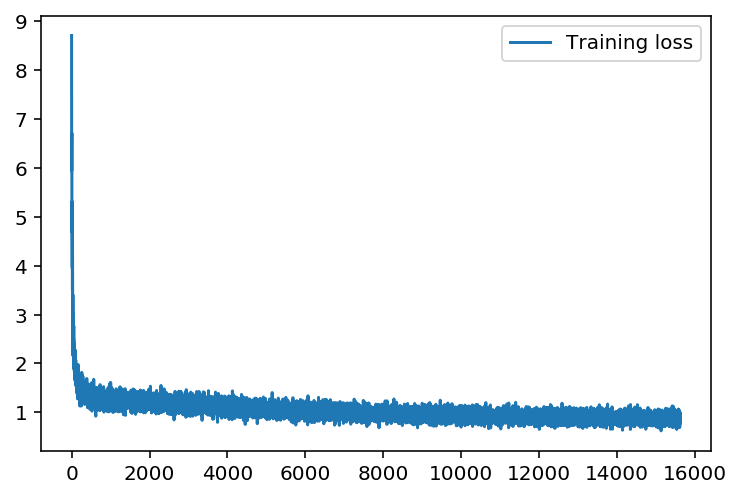

In [27]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
迭代次数再增加一些，下降的趋势会明显一些

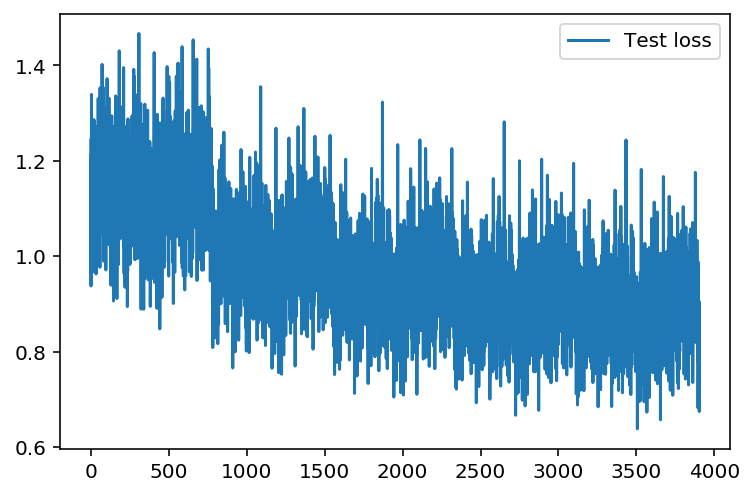

In [28]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 获取 Tensors
使用函数 [`get_tensor_by_name()`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name)从 `loaded_graph` 中获取tensors，后面的推荐功能要用到。

In [29]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") # 之前是MatMul:0 因为inference代码修改了 这里也要修改 感谢网友 @清歌 指出问题
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


## 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [30]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [31]:
rating_movie(234, 1401)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./save_model/save


[array([[3.1968396]], dtype=float32)]

## 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [32]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('./save_data/movie_matrics.p', 'wb'))

INFO:tensorflow:Restoring parameters from ./save_model/save


In [33]:
movie_matrics = pickle.load(open('./save_data/movie_matrics.p', mode='rb'))

## 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [34]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('./save_data/users_matrics.p', 'wb'))

INFO:tensorflow:Restoring parameters from ./save_model/save


In [35]:
users_matrics = pickle.load(open('./save_data/users_matrics.p', mode='rb'))

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [36]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [37]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save_model/save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
1098
[1114 'Funeral, The (1996)' 'Drama']
112
[114 "Margaret's Museum (1995)" 'Drama']
145
[147 'Basketball Diaries, The (1995)' 'Drama']
404
[408 '8 Seconds (1994)' 'Drama']
2453
[2522 "Airport '77 (1977)" 'Drama']


{112, 145, 404, 1098, 2453}

### 推荐您喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [38]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])

        return results


In [39]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save_model/save
以下是给您的推荐：
1130
[1146 "Curtis's Charm (1995)" 'Comedy|Drama']
911
[923 'Citizen Kane (1941)' 'Drama']
914
[926 'All About Eve (1950)' 'Drama']
1691
[1742 'Caught Up (1998)' 'Crime']
637
[642 'Roula (1995)' 'Drama']


{637, 911, 914, 1130, 1691}

### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [40]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [41]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save_model/save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[5767 'M' 25 2]
 [5102 'M' 25 12]
 [5610 'F' 25 1]
 [4142 'M' 56 7]
 [3213 'F' 25 1]
 [2316 'M' 35 0]
 [5079 'M' 25 4]
 [342 'M' 18 12]
 [100 'M' 35 17]
 [96 'F' 25 16]
 [371 'M' 18 4]
 [483 'M' 18 12]
 [2292 'M' 50 15]
 [5861 'F' 50 1]
 [2421 'M' 35 7]
 [3698 'M' 25 7]
 [2154 'M' 25 12]
 [4064 'M' 45 0]
 [5336 'M' 56 7]
 [4085 'F' 25 6]]
喜欢看这个电影的人还喜欢看：
900
[912 'Casablanca (1942)' 'Drama|Romance|War']
1773
[1842 'Illtown (1996)' 'Crime|Drama']
1178
[1196 'Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Drama|Sci-Fi|War']
1691
[1742 'Caught Up (1998)' 'Crime']
1180
[1198 'Raiders of the Lost Ark (1981)' 'Action|Adventure']


{900, 1178, 1180, 1691, 1773}

# 结论

以上就是实现的常用的推荐功能，将网络模型作为回归问题进行训练，得到训练好的用户特征矩阵和电影特征矩阵进行推荐。